# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.stats import gmean
from typing import Union, Optional

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1397
after merge with benchmark dates 1397
Original number of rows: 1397
Number of rows after aggregation: 967


In [3]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
# df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.177630
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.311554

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.4077e+01, final cost 2.4357e+00, first-order optimality 1.37e-04.


In [4]:
df_cap = df_cm1.copy(deep=True)

# load in data from the pcd
# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
pcd_dataset = pd.read_csv("data/all_ai_models_20250908.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (datapoints)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
df_cap.columns

Index(['model_id', 'estimated_capability', 'model', 'is_anchor', 'Model',
       'date', 'date_obj', 'compute', 'parameters', 'data'],
      dtype='object')

## Useful functions

In [5]:
# useful functions
# ------------------------------------------------------------------
# 0.  Data prep  ----------------------------------------------------
df = df_cap.copy()

# make sure the columns we’ll need exist and are typed correctly
for col in ["estimated_capability", "date", "compute"]:
    assert col in df.columns, f"missing {col}"
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

def later_lower_compute(
    row: pd.Series,
    df_level: pd.DataFrame,
    cap_tol_below: Union[int, float] = 0.1,
    cap_tol_above: Union[int, float] = 0.1,
) -> pd.DataFrame:
    """
    Return **all** models that are
      • released after ``row["date"]``,
      • use ≤ the same compute, and
      • have capability within ±``cap_tol`` of the current row.

    Parameters
    ----------
    cap_tol : float
        Half-width of the allowed capability band. Default 0.1 means we keep
        models whose capability lies in
        [row[cap_col] - 0.1, row[cap_col] + 0.1].

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    later_mask   = df_level["date"].gt(row["date"])
    compute_mask = df_level["compute"].le(row["compute"])

    lower_bound  = row["estimated_capability"] - cap_tol_below
    upper_bound  = row["estimated_capability"] + cap_tol_above
    cap_mask     = df_level["estimated_capability"].between(lower_bound, upper_bound, inclusive="both")


    later_matches = df_level.loc[later_mask & compute_mask & cap_mask]
    out = pd.concat([row.to_frame().T, later_matches]).sort_values("date")

    return out

# later_lower_compute(df.iloc[16], df, cap_tol=0.1) 16 18 22
# later_lower_compute(df.iloc[22], df, cap_tol_below=0.05, cap_tol_above=0.15)
# for i in range(len(df)):
#   print(i, len(later_lower_compute(df.iloc[i], df, cap_tol_below=0.05, cap_tol_above=2)))

In [6]:
# ------------------------------------------------------------
# Regression + numeric output
# ------------------------------------------------------------
def compute_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
) -> dict:
    """
    Fit  log10(compute) ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_log10              – slope in log10 units per year (should be < 0)
        factor_per_year          – 10**slope (e.g. 0.75 ⇒ 25 % drop/yr)
        pct_reduction_per_year   – (1-factor)*100
        intercept_log10, r_value, p_value, stderr
    """

    df = df_slice.copy()
    # ensure chronological order & datetime dtype
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # log-10 transform of compute
    y = np.log10(df[compute_col].astype(float))

    slope, intercept, r, p, se = linregress(years, y)

    factor_per_year        = 10 ** slope          # < 1 if slope negative
    pct_reduction_per_year = (1 - factor_per_year) * 100

    return {
        "slope_log10": slope,
        "intercept_log10": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
        "factor_per_year": 1/factor_per_year,
        "pct_reduction_per_year": pct_reduction_per_year,
    }


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
def plot_compute_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of compute vs date (log-y) with best-fit line overlaid.
    """
    stats = compute_regression_stats(df_slice, date_col=date_col, compute_col=compute_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # X for plotting
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # Fitted line in *linear* compute space
    y_fit_log10 = stats["intercept_log10"] + stats["slope_log10"] * years
    y_fit       = 10 ** y_fit_log10

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[compute_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_yscale("log")
    ax.set_xlabel("Date")
    ax.set_ylabel("Training compute")
    ax.set_title(
        title
        or "Compute trend (≈ constant capability)\n"
           f"≈ {stats['pct_reduction_per_year']:.1f}% less compute per year"
    )
    ax.legend()
    plt.tight_layout()

# Visualization

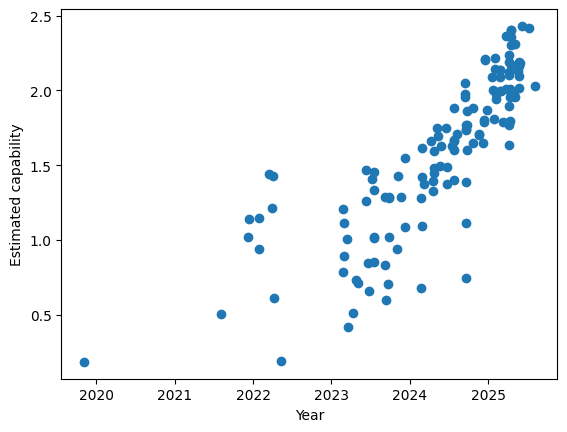

In [8]:
plt.scatter(df_cap["date_obj"], df_cap["estimated_capability"])
# plt.xscale("log")
plt.xlabel("Year")
plt.ylabel("Estimated capability")
plt.show()

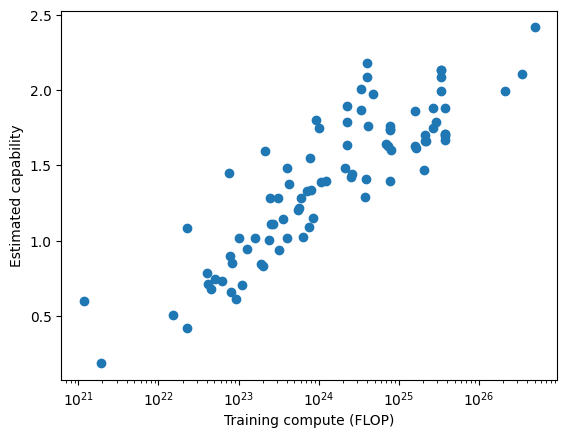

In [9]:
plt.scatter(df_cap["compute"], df_cap["estimated_capability"])
plt.xscale("log")
plt.xlabel("Training compute (FLOP)")
plt.ylabel("Estimated capability")
plt.show()

# Compute requirements reduction

In [10]:
n_min = 10
cap_tol_below = 0.05
cap_tol_above = 99
date_col = "date_obj"
compute_col = "compute"

results = []

for idx, anchor in df.iterrows():
    window = later_lower_compute(anchor, df,
                                  cap_tol_below=cap_tol_below,
                                  cap_tol_above=cap_tol_above)

    if len(window) < n_min:
        # not enough data → skip
        continue

    stats = compute_regression_stats(
        window, date_col=date_col, compute_col=compute_col
    )

    results.append(
        {
            "anchor_idx": idx,
            "anchor_date": anchor[date_col],
            "anchor_model": anchor["model"],
            "n_points": len(window),
            **stats,                     # slope_log10, factor_per_year, …
        }
    )

compute_reduction_df = pd.DataFrame(results)
compute_reduction_df[["anchor_model", "n_points", "factor_per_year", "p_value"]]

,anchor_model,n_points,factor_per_year,p_value
0,Gopher (280B),18,1.443384,0.137699
1,text-davinci-001,13,1.261690,0.496295
2,Megatron-Turing NLG 530B,15,1.442814,0.102257
3,text-davinci-002,13,1.127142,0.723185
4,PaLM 540B,14,0.905094,0.805527
5,gpt-neox-20b,12,1.373507,0.596433
6,gpt-4-0613,26,0.842753,0.769692
7,claude-2.0,16,0.464762,0.179471
8,falcon-180B,20,0.348544,0.023646
9,claude-3-opus-20240229,21,1.372200,0.622656


In [11]:
gmean(compute_reduction_df["factor_per_year"])

np.float64(1.9026335295737566)

Annual compute reduction ≈ 86.2% (7.231× per year)


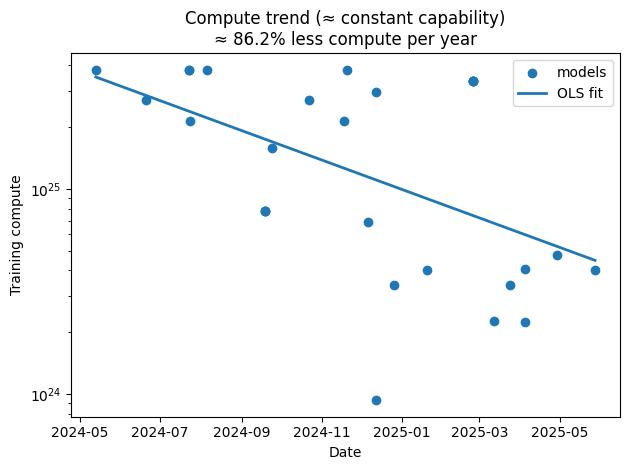

In [ ]:
window = later_lower_compute(df.loc[62], df,
                             cap_tol_below=cap_tol_below, cap_tol_above=cap_tol_above)
stats   = compute_regression_stats(window)
print(f"Annual compute reduction ≈ {stats['pct_reduction_per_year']:.1f}% "
      f"({stats['factor_per_year']:.3f}× per year)")

plot_compute_trend(window)

# Capabilities increase at fixed compute

In [13]:
# ---------------------------------------------------------------
# 0.  Data prep  -------------------------------------------------
df = df_cap.copy() 
for col in ["estimated_capability", "date", "compute"]:
    assert col in df.columns, f"missing {col}"
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")


def later_higher_capability(
    df_level: pd.DataFrame,
    *,
    compute_target: Union[int, float],
    date_from: Union[str, pd.Timestamp],
    compute_tol_below: Union[int, float] = 1.0,
    compute_tol_above: Union[int, float] = 1.0,
    # ―― choose *either* a relative improvement … ―――――――――――――――――――――――――――――
    compare_row: Optional[pd.Series] = None,
    # ―― … or an absolute capability floor (ignored if compare_row is given) ――
    cap_floor: Optional[Union[int, float]] = None,
) -> pd.DataFrame:
    """
    Return **all** models that
      • are released after *date_from*,
      • use ≈ the *compute_target* (|Δ| ≤ compute_tol), **and**
      • beat either:
          – compare_row["estimated_capability"] + min_cap_gain,   if *compare_row* is given, or
          – the absolute level *cap_floor*,                       otherwise.

    Parameters
    ----------
    compute_target : float
        The compute budget you want to hold (roughly) constant.
    compute_tol : float, default 0
        Half-width of the allowed compute band.
        e.g. 0.05 means keep models in [target-0.05, target+0.05].
        Use an absolute value; if you prefer relative %, multiply first.
    date_from : str | pd.Timestamp
        Cut-off date – only later releases are considered.
    compare_row : pd.Series, optional
        If provided we measure “higher capability” relative to this row.
        If omitted we fall back to *cap_floor* (must then be supplied).
    min_cap_gain : float, default 0.1
        The minimum improvement over *compare_row* we insist on.
    cap_floor : float, optional
        Absolute capability threshold if *compare_row* is None.

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    date_from = pd.to_datetime(date_from)

    # later in time ------------------------------------------------
    later_mask = df_level["date"].gt(date_from)

    # roughly equal compute ---------------------------------------
    lower_compute = compute_target / compute_tol_below
    upper_compute = compute_target * compute_tol_above
    compute_mask = df_level["compute"].between(lower_compute, upper_compute, inclusive="both")

    # capability strictly higher ----------------------------------
    if compare_row is not None:
        cap_threshold = compare_row["estimated_capability"]
    elif cap_floor is not None:
        cap_threshold = cap_floor
    else:
        raise ValueError("Supply either compare_row or cap_floor")

    cap_mask = df_level["estimated_capability"].gt(cap_threshold)

    # ----------------------------------------------------------------
    later_better = df_level.loc[later_mask & compute_mask & cap_mask]
    return later_better.sort_values("date")

for i in range(len(df)):
  baseline = df.loc[i]
  window = later_higher_capability(
      df,
      compute_target=baseline["compute"],
      date_from=baseline["date"],
      compare_row=baseline,
      compute_tol_below = 1000,
      compute_tol_above = 1.05
  )
  print(i, len(window))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 1
20 1
21 0
22 0
23 1
24 0
25 1
26 1
27 0
28 0
29 0
30 0
31 0
32 0
33 2
34 2
35 0
36 1
37 0
38 0
39 0
40 0
41 0
42 0
43 9
44 5
45 2
46 6
47 0
48 0
49 0
50 6
51 1
52 0
53 1
54 9
55 1
56 12
57 9
58 9
59 14
60 20
61 9
62 24
63 22
64 14
65 16
66 0
67 9
68 0
69 11
70 16
71 18
72 14
73 0
74 0
75 1
76 0
77 1
78 0
79 27
80 0
81 0
82 10
83 0
84 10
85 0
86 14
87 1
88 22
89 1
90 0
91 0
92 5
93 4
94 16
95 2
96 4
97 2
98 0
99 0
100 6
101 6
102 12
103 4
104 3
105 0
106 6
107 0
108 13
109 2
110 2
111 8
112 7
113 2
114 11
115 2
116 2
117 6
118 5
119 1
120 0
121 2
122 1
123 4
124 0
125 5
126 10
127 0
128 0
129 1
130 2
131 0
132 1


In [24]:
baseline = df.loc[62]
window = later_higher_capability(
    df,
    compute_target=baseline["compute"],
    date_from=baseline["date"],
    compare_row=baseline,
    compute_tol_below = 2,
    compute_tol_above = 1.05
)
window

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj,compute,parameters,data
56,m12,1.746222,claude-3-5-sonnet-20240620,False,Claude 3.5 Sonnet,2024-06-20,2024-06-20,2.700000e+25,NaN,NaN
43,m125,1.882331,Llama-3.1-405B,False,Llama 3.1-405B,2024-07-23,2024-07-23,3.800000e+25,4.050000e+11,1.560000e+13
60,m6,1.708020,gpt-4o-2024-08-06,False,GPT-4o,2024-08-06,2024-08-06,3.810001e+25,NaN,NaN
44,m9,1.881043,claude-3-5-sonnet-20241022,False,Claude 3.5 Sonnet,2024-10-22,2024-10-22,2.700000e+25,NaN,NaN
61,m46,1.704978,mistral-large-2411,False,Mistral Large 2,2024-11-18,2024-11-18,2.130000e+25,1.230000e+11,NaN
59,m38,1.708601,gpt-4o-2024-11-20,False,GPT-4o,2024-11-20,2024-11-20,3.810001e+25,NaN,NaN
50,m25,1.788050,grok-2-1212,False,Grok-2,2024-12-12,2024-12-12,2.960000e+25,NaN,NaN
26,m47,2.089862,claude-3-7-sonnet-20250219_16K,False,Claude 3.7 Sonnet,2025-02-24,2025-02-24,3.350000e+25,NaN,NaN
19,m50,2.134703,claude-3-7-sonnet-20250219_32K,False,Claude 3.7 Sonnet,2025-02-24,2025-02-24,3.350000e+25,NaN,NaN
20,m73,2.134646,claude-3-7-sonnet-20250219_64K,False,Claude 3.7 Sonnet,2025-02-24,2025-02-24,3.350000e+25,NaN,NaN


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1 A.  Regression stats
# ------------------------------------------------------------
def capability_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
) -> dict:
    """
    Fit  capability ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_per_year            – capability units gained per year
        intercept, r_value, p_value, stderr
    """
    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    y = df[cap_col].astype(float)

    slope, intercept, r, p, se = linregress(years, y)

    return {
        "slope_per_year": slope,
        "intercept": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
    }

# ------------------------------------------------------------
# 1 B.  Plot capability trend
# ------------------------------------------------------------
def plot_capability_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of capability vs date (linear y) with best-fit line.
    """
    stats = capability_regression_stats(df_slice, date_col=date_col, cap_col=cap_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )
    y_fit = stats["intercept"] + stats["slope_per_year"] * years

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[cap_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated capability")
    ax.set_title(
        title
        or "Capability trend (≈ constant compute)\n"
           f"≈ {stats['slope_per_year']:.3f} capability units gained per year"
    )
    ax.legend()
    plt.tight_layout()

# ------------------------------------------------------------
# 2.  Iterate over anchors, build summary table
# ------------------------------------------------------------
n_min = 5                       # require ≥ this many points in a window
compute_tol_below = 1e5
compute_tol_above = 1.05

results = []

for idx, anchor in df.iterrows():
    window = later_higher_capability(
        df,
        compute_target=anchor["compute"],
        date_from=anchor["date"],
        compare_row=anchor,
        compute_tol_below=compute_tol_below,
        compute_tol_above=compute_tol_above,
    )

    if len(window) < n_min:
        continue        # not enough data → skip

    stats = capability_regression_stats(window)

    results.append(
        {
            "anchor_idx": idx,
            "anchor_model": anchor["model"],
            "anchor_date": anchor["date"],
            "n_points": len(window),
            **stats,                         # slope_per_year, r_value, …
        }
    )

summary_df = pd.DataFrame(results)
summary_df

,anchor_idx,anchor_model,anchor_date,n_points,slope_per_year,intercept,r_value,p_value,stderr
0,108,Gopher (280B),2021-12-08,13,0.084072,1.130166,0.456793,0.116606,0.049365
1,114,text-davinci-001,2022-01-27,11,0.217877,1.016697,0.506047,0.112235,0.123783
2,102,Megatron-Turing NLG 530B,2022-01-28,12,0.121965,1.167617,0.614609,0.033455,0.049502
3,82,text-davinci-002,2022-03-15,10,0.225137,1.486123,0.694008,0.025988,0.082575
4,100,Chinchilla (70B),2022-03-29,6,0.267869,1.284143,0.566344,0.241310,0.194907
5,84,PaLM 540B,2022-04-04,10,0.225137,1.486123,0.694008,0.025988,0.082575
6,126,gpt-neox-20b,2022-04-07,10,0.149044,0.775446,0.330995,0.350195,0.150228
7,101,LLaMA-65B,2023-02-24,6,0.267869,1.284143,0.566344,0.241310,0.194907
8,112,falcon-40b,2023-03-15,7,0.233116,1.106742,0.428652,0.337268,0.219734
9,79,gpt-4-0613,2023-06-13,27,0.313663,1.489099,0.731240,0.000015,0.058519


In [26]:
s = summary_df["slope_per_year"].dropna().to_numpy()
positive = s[s > 0]
geo_mean = gmean(positive) if positive.size else np.nan
geo_mean


np.float64(0.29971379216498795)

In [27]:
np.mean(summary_df["slope_per_year"])

np.float64(0.2688887787594697)

24


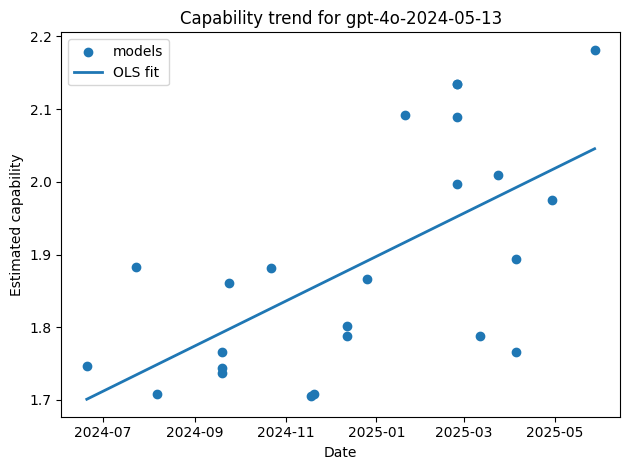

In [ ]:
baseline = df.loc[62]
window = later_higher_capability(
    df,
    compute_target=baseline["compute"],
    date_from=baseline["date"],
    compare_row=baseline,
    compute_tol_below=1000,
    compute_tol_above=1.05,
)

print(len(window))

plot_capability_trend(window, title=f"Capability trend for {baseline['model']}")